## Load and Evaluate the Experiments

This notebook is an interactive testing environment for now and will be used to generate the final plots for the accompanying paper. [Paper Citation]

## 1. Import Libraries

In [1]:
# ----------------
# import libraries
# ----------------

# standard libraries
# -----
import os
import sys
import random
import datetime


import numpy as np
from tqdm import tqdm
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torchvision import transforms

# configuration module
# -----

sys.path.append(os.path.dirname(sys.path[0]))
#import config
from config import args

# define manual random seed
torch.manual_seed(args.seed)
random.seed(args.seed)
np.random.seed(args.seed)

# custom libraries
# -----
from utils.general import save_model, load_model, save_args, AverageMeter, DotDict
from utils.configurator import get_augmentations, get_dataloaders, get_network, get_optimizer, get_scheduler, update_lr, get_loss
from utils.evaluation import fuse_representations, lls_fit, lls_eval, supervised_eval, knn_eval, wcss_bcss, get_pacmap, train_linear_classifier, evaluate, log_to_tensorboard
from utils.visualization import ConfusionMatrix
from utils.networks import LinearClassifier, DoubleOutput

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# macOS does do its own multiprocessing and does not like it prescribed
args.num_workers = 0 if torch.backends.mps.is_available() else args.num_workers


data_properties_dict = {
    'C3': DotDict({'rgb_mean': (0.3621, 0.3644, 0.3635),
           'rgb_std': (0.1456, 0.1479, 0.1477),
           'classes': [str(c) for c in range(0,50)],
           'n_classes': 50,
           }),
}

In [3]:
args.exp_dir = "/Users/markus/Research/Code/ColorConstancyLearning/learning/save/12-12-23_16-20__seed_0_C3_aug_time_SimCLR_reg_None"
# get the model you want to load
model_path = args.exp_dir + '/models/' + 'backbone_epoch_100.pt'
model = get_network(args, data_properties_dict).to(device)
load_model(model, model_path, device)
#model.load_state_dict(torch.load(model_path, map_location=torch.device('mps')))
model.eval()

# the DoubleOutput class is just needed because the fuse_representations function
# expects an output of (representation, projection) to work within the training loop
# and an encoder method that is only part of the network - I am faking this here with
# sequential modules to extract more representations

class layer3(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder = torch.nn.Sequential(
                        model.layer1,
                        model.layer2,
                        model.layer3,
        )
        self.out =  torch.nn.Sequential(
            self.encoder,
            DoubleOutput(),
        )

    def forward(self, x):
        return self.out(x)

l3 = layer3()
l3.eval()

class layer2(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder = torch.nn.Sequential(
                        model.layer1,
                        model.layer2,
                        torch.nn.Flatten(),
        )
        self.out =  torch.nn.Sequential(
            self.encoder,
            DoubleOutput(),
        )

    def forward(self, x):
        return self.out(x)

l2 = layer2()
l2.eval()

class layer1(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder = torch.nn.Sequential(
                        model.layer1,
                        torch.nn.Flatten(),
        )
        self.out =  torch.nn.Sequential(
            self.encoder,
            DoubleOutput(),
        )

    def forward(self, x):
        return self.out(x)

l1 = layer1()
l1.eval()


class layer0(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder = torch.nn.Sequential(
                        torch.nn.Flatten(),
        )
        self.out =  torch.nn.Sequential(
            self.encoder,
            DoubleOutput(),
        )

    def forward(self, x):
        return self.out(x)

l0 = layer0()
l0.eval()

#classifier.eval()

layer0(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
  )
  (out): Sequential(
    (0): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
    )
    (1): DoubleOutput()
  )
)

In [4]:
args.data_root = "/Users/markus/Research/Code/ColorConstancyLearning/learning/data"
# get the dataloaders for the dataset
dataloader_train, dataloader_train_eval, dataloader_test = get_dataloaders(
    args, data_properties_dict)

[INFO:] Training set at '/Users/markus/Research/Code/ColorConstancyLearning/learning/data/C3/train'
[INFO:] Evaluation Training set at '/Users/markus/Research/Code/ColorConstancyLearning/learning/data/C3/train'
[INFO:] Test set at '/Users/markus/Research/Code/ColorConstancyLearning/learning/data/C3/test'


tensor(0.7308)
tensor(0.1946)
tensor(0.3424)
tensor(0.7554)


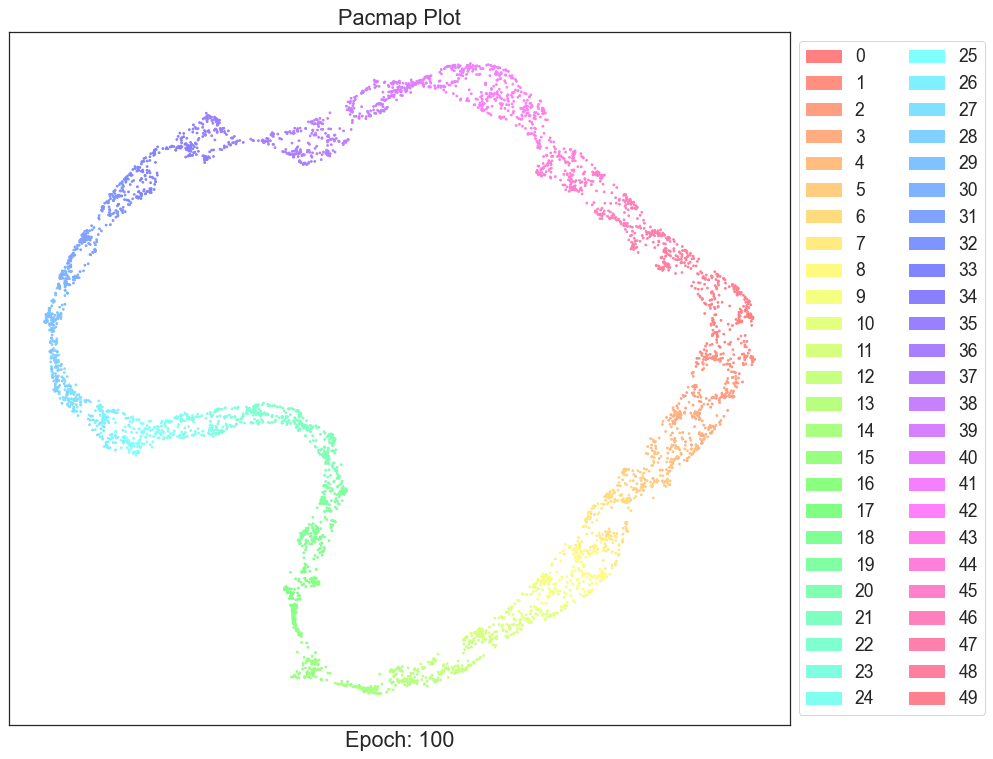

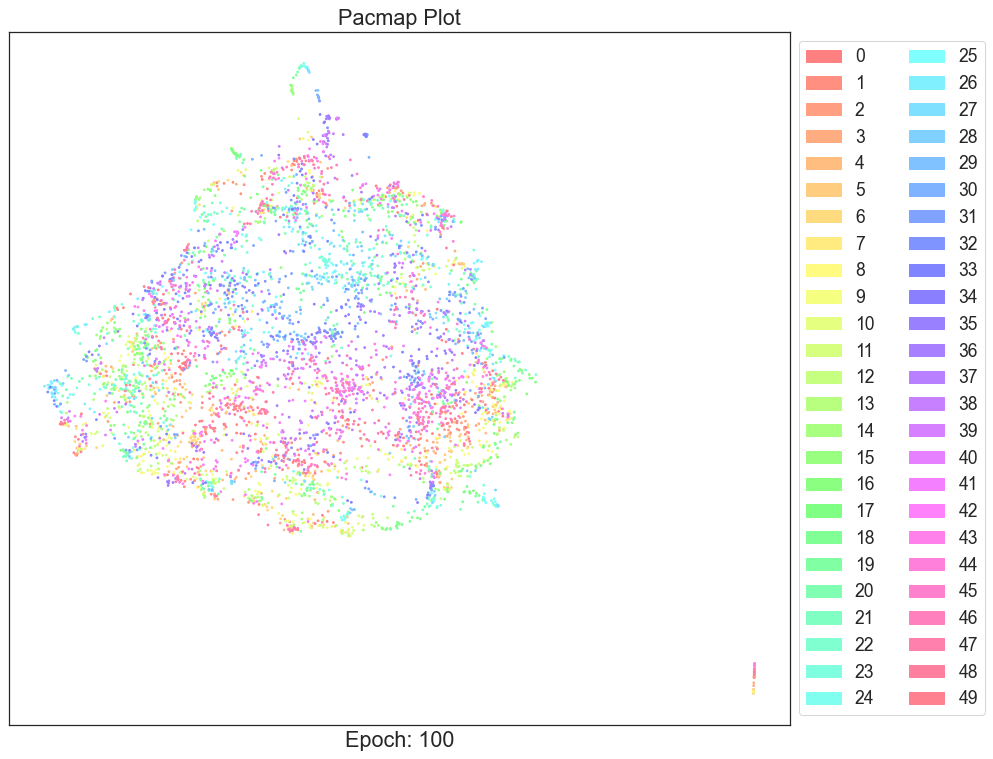

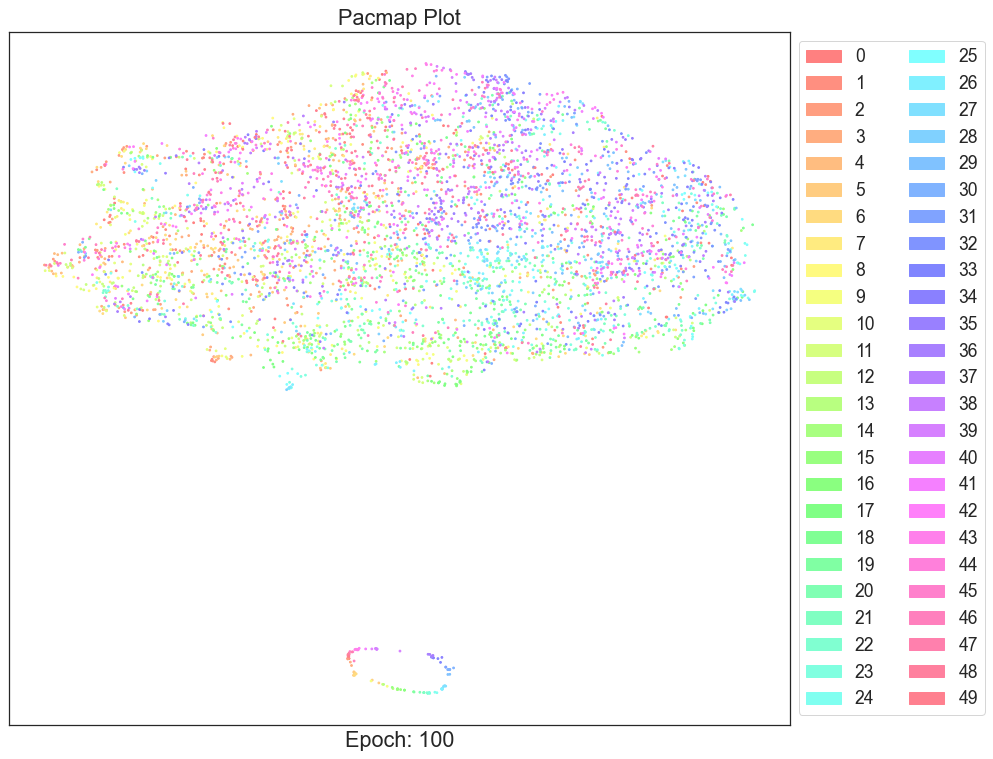

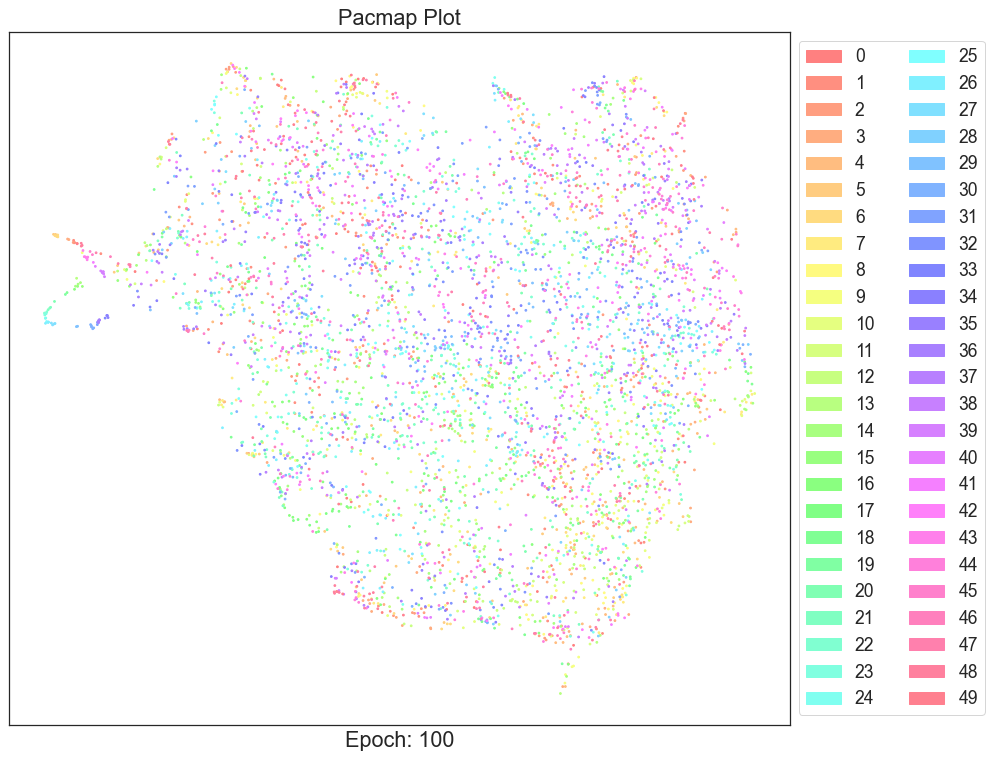

In [5]:
for layer in [l3, l2, l1, l0]:
# do the standard evaluation on the unsupervised representation
    features_train_eval, labels_train_eval = fuse_representations(
        layer, dataloader_train_eval, device=device)
    features_test, labels_test = fuse_representations(
        layer, dataloader_test, device=device)
    lstsq_model = lls_fit(features_train_eval,
                          labels_train_eval,
                          data_properties_dict[args.dataset].n_classes,
                          scipy=True)
    pred, test_acc = lls_eval(lstsq_model,
                              features_test,
                              labels_test)
    wb = wcss_bcss(features_test,
                   labels_test,
                   data_properties_dict[args.dataset].n_classes)
    pacmap_plot = get_pacmap(
        features_test,
        labels_test,
        100,
        data_properties_dict[args.dataset].n_classes,
        data_properties_dict[args.dataset].classes)
    print(test_acc)

In [6]:
for layer, out_dim in zip([l3, l2, l1, l0],[84,400,1176,3072]):
    train_loss, train_acc, test_loss, test_acc, = train_linear_classifier(
    dataloader_train_eval,
    dataloader_test,
    out_dim,
    data_properties_dict[args.dataset].n_classes,
    model=layer,
    confusion_matrix=None,
    epochs=25,#args.linear_nn_epochs,
    timestep=100,#epoch + 1,
    test_every=1,#args.linear_nn_test_every,
    writer=None,
    device=device)
    print(train_loss, train_acc, test_loss, test_acc)


[INFO:] Starting linear evaluation with Neural Network at epoch 101


Loss:   1.1774: 100%|███████████████████████████| 25/25 [01:46<00:00,  4.25s/it]


1.1448601579666138 0.8755333333333334 1.1774337221594418 0.7612

[INFO:] Starting linear evaluation with Neural Network at epoch 101


Loss:   2.1433: 100%|███████████████████████████| 25/25 [01:43<00:00,  4.15s/it]


1.6819063591957093 0.49166666666666664 2.143253571846906 0.2302

[INFO:] Starting linear evaluation with Neural Network at epoch 101


Loss:   2.1896: 100%|███████████████████████████| 25/25 [01:42<00:00,  4.09s/it]


1.6964273715019227 0.45866666666666667 2.189613370334401 0.231

[INFO:] Starting linear evaluation with Neural Network at epoch 101


Loss:   1.9965: 100%|███████████████████████████| 25/25 [01:37<00:00,  3.89s/it]

1.6693751907348633 0.4052 1.9964662369559794 0.297
